In [ ]:
# Import necessary libraries
import json
from nltk import word_tokenize
import numpy as np
import glob
from tqdm import tqdm
import nltk


In [ ]:
# Uploading the training data and GLoVe Embedding to your Google Drive

# Connecting this Google Colab to your Google Drive storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if an Nvidia GPU is available
# https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm
!nvidia-smi

Mon May 30 03:11:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def load_glove(path, dim=300):
    """
    GLoVe embedding is a way to map a word into a fixed-dimension vector.
    This function load the GLoVe embedding
    :param path:
    :param dim: dimesion of the word vector
    :return: a 2D numpy matrix and a dictionary that maps a word into index in the numpy matrix
    """
    matrix = []
    word_index = dict()

    # Adding a zero vector of the same size as "<PAD>" token, index of 0
    # Adding a random vector of the same size as "<UNK>" token, index of 1

    matrix.append([0.] * dim)
    matrix.append([0.] * dim)
    word_index['<PAD>'] = 0
    word_index['<UNK>'] = 1
    # Load from glove
    #
    with open(path, encoding='latin-1') as f:
        lines = f.readlines()
        for l in lines:
            parts = l.split(' ')
            vector = [float(x) for x in parts[1:]]
            matrix.append(vector)
            word_index[parts[0]] = len(word_index)

    matrix = np.array(matrix, dtype=np.float)
    return matrix, word_index

In [ ]:
# Actually call the function to load the GLoVe
import os
matrix, word_index = load_glove('drive/MyDrive/temp/glove.6B.50d.txt', 50)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
# More libraries and download data for the word tokenizer.

import torch
from torch.utils.data import Dataset
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# A "Dataset" class manage the loading/preprocessing/sampling/packaging of input data
# It is used by a "DataLoader" in the later part of the code
class ImdbDataset(Dataset):

    def __init__(self, data_file_path, word_index, max_length):
        super(ImdbDataset, self).__init__()
        self.word_index = word_index
        # Paragraph max length
        self.ML = max_length
        # Load data from data_file_path
        self.data = load_json(data_file_path)
        # Target is an integer representing a class
        # E.g. label="positive" -> target=1
        #      label="negative" -> target=0
        self.target_map ={
            'positive': 1,
            'negative': 0
        }


    def __len__(self):
        # Returning the length of the dataset, basically, the number of data points
        return len(self.data)

    def all_targets(self):
        # Returning all the targets of the dataset, orderly.
        return [x['target'] for x in self.data]

    def __getitem__(self, idx):
        """
        :param idx: an index of a data point from the dataset.
        """
        # Just picking it from self.data
        item = self.data[idx]

        # Tokenize and initialize the target for each data point.
        # Tokenize paragraphs into words and punctuations
        # Each of the splitted string is called a "token"

        tokens = word_tokenize(item['text'].lower())

        # Indices stores the index of the token in the GLoVe embedding matrix
        indices = []
        for x in tokens:
          if x in word_index:
              indices.append(word_index[x])
          else:
              indices.append(word_index['<UNK>'])

        # Croping the sentence upto a certain length
        indices = indices[:self.ML]
        target = self.target_map[item['label']]

        # Pad sentence: append <pad_token_index> to the sentence which is shorter than maximum length.
        l = len(indices)
        if l < self.ML:
            indices += [0 for _ in range(self.ML - l)] # 0 is the index of a dummy pad token

        # Make sure that the sentence is cropped and padded correctly
        assert len(indices) == self.ML
        return {
            'indices': indices,
            'target': target
        }

    @staticmethod
    def pack(items):
        """
        :param items: list of items, each item is an object returned from __getitem__ function
        :return:
        """
        # Pack item into batch
        # Each batch is a dictionary (similar to each item)
        batch = {
            'indices': torch.LongTensor([x['indices'] for x in items]),
            'target': torch.LongTensor([x['target'] for x in items])
        }
        return batch

In [ ]:
# Calculating the accuracy score

from sklearn.metrics import accuracy_score
def metrics(predictions: list, targets: list):
    """

    :param predictions:
    :param targets:
    :return:
    """
    return accuracy_score(targets, predictions)


In [ ]:
def load_json(path):
    """
    Load a json file, return the data
    :param path:
    :return:
    """
    print('Loading', path, end=' ')
    with open(path, 'r', encoding='latin-1') as f:
        data = json.load(f)
    print(len(data))
    return data

In [ ]:
# Defining hyperparameters
# This help the finetuning more organized

# ADJUSTING THESE HYPERPARAMETERS

class Argument:
  n_class= 2    # Number of classes (dont change this)
  max_length= 384  # Maximum length of the text will be feed to the model    Try [64:1024]

  glove= 'drive/MyDrive/temp/glove.6B.50d.txt'  # GLoVe embedding version, try all given versions
  
  # Model arguments
  dropout= 0.2          # Dropout rate          Try [0.2:0.8]
  hidden_size= 128      # Hidden layer size     Try [64:512]
  kernel_size= 5        # CNN kernel size       Try [3,5,7,9,11]

  # Training arguments
  epoch= 30            # Number of training epochs.  Try [20:200]
  lr= 0.0075              # Learning rate               Try [1e-2:1e-4]
  batch_size= 48       # Batch size                  Try [32:128]
  optimizer= torch.optim.SGD        # Optimizer       Try [SGD, Adam, Adadelta]

  
args = Argument

# Setup the CUDA device
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
args = Argument
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Make sure the cuda is used
print('Using device: ', args.device)

Using device:  cuda


In [ ]:
import torch.nn as nn

# This is a simple version of the CNN for text classification proposed by Yoon Kim
# Access the paper here: https://arxiv.org/pdf/1408.5882.pdf
class BaseModel(nn.Module):

    def __init__(self, embedding_matrix, args):
        """
        :param: embedding_matrix: the GLoVe embedding matrix
        :param: args: an object of "Argument" class, this class is defined in the later part of the code
        """

        super(BaseModel, self).__init__()
        self.device = args.device
        hidden_size = args.hidden_size

        # creating an embedding module
        N, D = embedding_matrix.shape
        self.embedding = nn.Embedding(N, D, _weight=torch.FloatTensor(embedding_matrix))

        # Disabling gradient update of embedding
        self.embedding.weight.requires_grad = False
        self.embedding_dim = D


        # Define the layers
        self.conv = nn.Conv1d(D, hidden_size, kernel_size=args.kernel_size)
        self.max_pool = nn.MaxPool1d(args.max_length - args.kernel_size + 1)
        self.fc = nn.Sequential(
            nn.Tanh(),
            nn.Dropout(args.dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Dropout(args.dropout),
            nn.Linear(args.hidden_size, args.n_class)
        )

    def forward(self, batch):
        # B denotes batch_size
        # L denotes sentence length
        # D denotes vector dimension

        # Get embedding
        embedding = self.embedding(batch['indices'].to(self.device))  # size of (B x L x D)
        # print('| embedding', tuple(embedding.shape))
        x = embedding.transpose(dim0=1, dim1=2)  # B x D x L
        # Feed through the neural network
        conv_x = self.conv(x)  # B x D x L
        # print('| conv_x', tuple(conv_x.shape))

        max_pool = self.max_pool(conv_x) # B x D x 1
        max_pool = max_pool.squeeze(dim=2) # B x D
        # print('| max_pool', tuple(max_pool.shape))

        logits = self.fc(max_pool)

        # print('| logits', tuple(logits.shape))


        # Calculating the prediction
        predictions = torch.argmax(logits, dim=-1)

        return logits, predictions

In [ ]:
# Creating a dataloader object
from torch.utils.data import DataLoader

# Shorter = faster training, Longer=(possibly) higher accuracy
train_dataset = ImdbDataset('drive/MyDrive/temp/train.json', word_index, args.max_length)
dev_dataset = ImdbDataset('drive/MyDrive/temp/dev.json', word_index, args.max_length)

train_dl = DataLoader(train_dataset, 
                      batch_size=args.batch_size, # Mini-batch
                      shuffle=True,               # Stochastic 
                      num_workers=2,              # 4 external processes dedicated for preprocessing data
                      collate_fn=ImdbDataset.pack)# Pack separate samples into a batch
dev_dl = DataLoader(dev_dataset, 
                    batch_size=args.batch_size, 
                    shuffle=False,                # Don't shuffle in evaluation
                    num_workers=2,
                    collate_fn=ImdbDataset.pack)
# Loading GLoVe embedding
embedding_matrix, _ = load_glove(args.glove, dim=50)



Loading drive/MyDrive/temp/train.json 25000
Loading drive/MyDrive/temp/dev.json 25000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
# Creating the model object
model = BaseModel(embedding_matrix, args)
# Sending the model to GPU
model.to(args.device)

# Selecting all trainable parameters
params = [x for x in model.parameters() if x.requires_grad == True]
# Creating an optimizer object
optimizer = args.optimizer(params, lr=args.lr)
# Printing out to see the model architecture
print(model)

BaseModel(
  (embedding): Embedding(400002, 50)
  (conv): Conv1d(50, 128, kernel_size=(5,), stride=(1,))
  (max_pool): MaxPool1d(kernel_size=380, stride=380, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Tanh()
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


def train_and_evaluate(model, train_dl, dev_dl, optimizer, args):
    """
    Implementation of stochastic gradient decent
    """
    loss_fn = torch.nn.CrossEntropyLoss()
    global dev_loss_list
    global train_loss_list
    global train_acc_list
    global dev_acc_list
    dev_loss_list = []
    train_loss_list = []
    train_acc_list = []
    dev_acc_list = []

    for e in range(args.epoch):
        train_loss = 0
        dev_loss = 0

        # Training
        model.train()
        train_targets, train_preds = [], []
        for batch in tqdm(train_dl, desc='Train'):
            optimizer.zero_grad()
            logits, preds = model(batch)
            train_preds += preds.detach().cpu().numpy().tolist()
            targets = batch['target'].numpy().tolist()
            train_targets += targets
            loss = loss_fn(logits, batch['target'].to(args.device))
            loss.backward()
            # Printing loss 
            train_loss += loss.item()
            optimizer.step()

        avg_train_loss = (train_loss/len(train_dl))
        print("Train loss:", avg_train_loss )
        train_loss_list.append(avg_train_loss)
        train_acc = metrics(train_preds, train_targets)
        train_acc_list.append(train_acc)

        # Printing train_acc
        print(" Training acc:", train_acc)

        # Evaluation
        model.eval()
        dev_targets, dev_preds = [], []
        for batch in tqdm(dev_dl, desc="Dev"):
            _, preds = model(batch)
            dev_preds += preds.detach().cpu().numpy().tolist()
            targets = batch['target'].numpy().tolist()
            dev_targets += targets
            #computing dev loss and printing
            loss = loss_fn(_, batch['target'].to(args.device))
            dev_loss += loss.item()
        
        avg_dev_loss = (dev_loss/len(dev_dl))
        print("Dev loss:", avg_dev_loss )
        dev_loss_list.append(avg_dev_loss)
        dev_acc = metrics(dev_preds, dev_targets)
        dev_acc_list.append(dev_acc)
        # printing dev_acc
        print(" Dev acc:", dev_acc)

        # Logging the epoch and scores
        print(f'Epoch {e} Train={train_acc:.4f} Dev={dev_acc:.4f}')
# Actual training
train_and_evaluate(model, train_dl, dev_dl, optimizer, args)



Train: 100%|██████████| 521/521 [00:42<00:00, 12.22it/s]


Train loss: 0.6947900130057747
 Training acc: 0.5094


Dev: 100%|██████████| 521/521 [00:40<00:00, 12.97it/s]


Dev loss: 0.692098564927729
 Dev acc: 0.5008
Epoch 0 Train=0.5094 Dev=0.5008


Train: 100%|██████████| 521/521 [00:41<00:00, 12.64it/s]


Train loss: 0.6917869288495773
 Training acc: 0.52084


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.13it/s]


Dev loss: 0.6863162125140829
 Dev acc: 0.55328
Epoch 1 Train=0.5208 Dev=0.5533


Train: 100%|██████████| 521/521 [00:41<00:00, 12.57it/s]


Train loss: 0.6854801296958997
 Training acc: 0.55104


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.27it/s]


Dev loss: 0.6800588135984718
 Dev acc: 0.61628
Epoch 2 Train=0.5510 Dev=0.6163


Train: 100%|██████████| 521/521 [00:41<00:00, 12.66it/s]


Train loss: 0.6774690974925621
 Training acc: 0.58344


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.12it/s]


Dev loss: 0.6722669991559121
 Dev acc: 0.58364
Epoch 3 Train=0.5834 Dev=0.5836


Train: 100%|██████████| 521/521 [00:41<00:00, 12.54it/s]


Train loss: 0.6628256147287629
 Training acc: 0.6142


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.04it/s]


Dev loss: 0.6510473601877576
 Dev acc: 0.65608
Epoch 4 Train=0.6142 Dev=0.6561


Train: 100%|██████████| 521/521 [00:41<00:00, 12.49it/s]


Train loss: 0.6421165714565943
 Training acc: 0.64028


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.06it/s]


Dev loss: 0.6236875832881671
 Dev acc: 0.67024
Epoch 5 Train=0.6403 Dev=0.6702


Train: 100%|██████████| 521/521 [00:41<00:00, 12.45it/s]


Train loss: 0.6069846324293718
 Training acc: 0.681


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.04it/s]


Dev loss: 0.5842482409298763
 Dev acc: 0.701
Epoch 6 Train=0.6810 Dev=0.7010


Train: 100%|██████████| 521/521 [00:41<00:00, 12.64it/s]


Train loss: 0.5656394244041186
 Training acc: 0.71552


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.05it/s]


Dev loss: 0.5326596405249868
 Dev acc: 0.744
Epoch 7 Train=0.7155 Dev=0.7440


Train: 100%|██████████| 521/521 [00:41<00:00, 12.69it/s]


Train loss: 0.5209089192113125
 Training acc: 0.74916


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.33it/s]


Dev loss: 0.49361420907580694
 Dev acc: 0.76852
Epoch 8 Train=0.7492 Dev=0.7685


Train: 100%|██████████| 521/521 [00:40<00:00, 12.84it/s]


Train loss: 0.49103332978750147
 Training acc: 0.76732


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.23it/s]


Dev loss: 0.46828171210417135
 Dev acc: 0.7816
Epoch 9 Train=0.7673 Dev=0.7816


Train: 100%|██████████| 521/521 [00:40<00:00, 12.73it/s]


Train loss: 0.4657515456145647
 Training acc: 0.78232


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.16it/s]


Dev loss: 0.44818381144309455
 Dev acc: 0.79232
Epoch 10 Train=0.7823 Dev=0.7923


Train: 100%|██████████| 521/521 [00:40<00:00, 12.76it/s]


Train loss: 0.4497842073097339
 Training acc: 0.7904


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.09it/s]


Dev loss: 0.4359054864310944
 Dev acc: 0.7984
Epoch 11 Train=0.7904 Dev=0.7984


Train: 100%|██████████| 521/521 [00:40<00:00, 12.72it/s]


Train loss: 0.43542638684188567
 Training acc: 0.79908


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.25it/s]


Dev loss: 0.43362288468744387
 Dev acc: 0.80076
Epoch 12 Train=0.7991 Dev=0.8008


Train: 100%|██████████| 521/521 [00:40<00:00, 12.79it/s]


Train loss: 0.422266104142405
 Training acc: 0.80616


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.23it/s]


Dev loss: 0.4190436457489365
 Dev acc: 0.80696
Epoch 13 Train=0.8062 Dev=0.8070


Train: 100%|██████████| 521/521 [00:40<00:00, 12.84it/s]


Train loss: 0.4128011665280172
 Training acc: 0.8118


Dev: 100%|██████████| 521/521 [00:38<00:00, 13.45it/s]


Dev loss: 0.43861372429956175
 Dev acc: 0.79644
Epoch 14 Train=0.8118 Dev=0.7964


Train: 100%|██████████| 521/521 [00:40<00:00, 12.75it/s]


Train loss: 0.40519364478492004
 Training acc: 0.816


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.29it/s]


Dev loss: 0.40980749441428743
 Dev acc: 0.81456
Epoch 15 Train=0.8160 Dev=0.8146


Train: 100%|██████████| 521/521 [00:40<00:00, 12.89it/s]


Train loss: 0.3971419591821315
 Training acc: 0.819


Dev: 100%|██████████| 521/521 [00:38<00:00, 13.41it/s]


Dev loss: 0.41649158673643377
 Dev acc: 0.808
Epoch 16 Train=0.8190 Dev=0.8080


Train: 100%|██████████| 521/521 [00:40<00:00, 12.85it/s]


Train loss: 0.3872314242792679
 Training acc: 0.826


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.28it/s]


Dev loss: 0.4441582330014564
 Dev acc: 0.7932
Epoch 17 Train=0.8260 Dev=0.7932


Train: 100%|██████████| 521/521 [00:40<00:00, 12.88it/s]


Train loss: 0.38010345482322855
 Training acc: 0.82932


Dev: 100%|██████████| 521/521 [00:38<00:00, 13.43it/s]


Dev loss: 0.4026629589569546
 Dev acc: 0.81672
Epoch 18 Train=0.8293 Dev=0.8167


Train: 100%|██████████| 521/521 [00:40<00:00, 12.84it/s]


Train loss: 0.36988387695887265
 Training acc: 0.8352


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.16it/s]


Dev loss: 0.4312198195685123
 Dev acc: 0.80068
Epoch 19 Train=0.8352 Dev=0.8007


Train: 100%|██████████| 521/521 [00:41<00:00, 12.68it/s]


Train loss: 0.3618199393696611
 Training acc: 0.83904


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.32it/s]


Dev loss: 0.4526955011996106
 Dev acc: 0.78984
Epoch 20 Train=0.8390 Dev=0.7898


Train: 100%|██████████| 521/521 [00:40<00:00, 12.82it/s]


Train loss: 0.3588816391986986
 Training acc: 0.84272


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.26it/s]


Dev loss: 0.39767277804194395
 Dev acc: 0.8194
Epoch 21 Train=0.8427 Dev=0.8194


Train: 100%|██████████| 521/521 [00:40<00:00, 12.86it/s]


Train loss: 0.3473896831846054
 Training acc: 0.85072


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.36it/s]


Dev loss: 0.39753003870342607
 Dev acc: 0.8196
Epoch 22 Train=0.8507 Dev=0.8196


Train: 100%|██████████| 521/521 [00:40<00:00, 12.79it/s]


Train loss: 0.3453082677956506
 Training acc: 0.84892


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.27it/s]


Dev loss: 0.40397527281931406
 Dev acc: 0.81656
Epoch 23 Train=0.8489 Dev=0.8166


Train: 100%|██████████| 521/521 [00:40<00:00, 12.80it/s]


Train loss: 0.3303024844908211
 Training acc: 0.85496


Dev: 100%|██████████| 521/521 [00:38<00:00, 13.39it/s]


Dev loss: 0.40159981979518383
 Dev acc: 0.8194
Epoch 24 Train=0.8550 Dev=0.8194


Train: 100%|██████████| 521/521 [00:40<00:00, 12.90it/s]


Train loss: 0.33255006441571205
 Training acc: 0.85516


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.28it/s]


Dev loss: 0.3902057936690362
 Dev acc: 0.82408
Epoch 25 Train=0.8552 Dev=0.8241


Train: 100%|██████████| 521/521 [00:40<00:00, 12.87it/s]


Train loss: 0.3247673863298376
 Training acc: 0.85856


Dev: 100%|██████████| 521/521 [00:38<00:00, 13.38it/s]


Dev loss: 0.3966844214301649
 Dev acc: 0.821
Epoch 26 Train=0.8586 Dev=0.8210


Train: 100%|██████████| 521/521 [00:40<00:00, 12.84it/s]


Train loss: 0.32094647828310785
 Training acc: 0.86148


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.21it/s]


Dev loss: 0.3904393863025874
 Dev acc: 0.82472
Epoch 27 Train=0.8615 Dev=0.8247


Train: 100%|██████████| 521/521 [00:40<00:00, 12.86it/s]


Train loss: 0.3128671387421421
 Training acc: 0.86556


Dev: 100%|██████████| 521/521 [00:38<00:00, 13.40it/s]


Dev loss: 0.4159727981331939
 Dev acc: 0.8124
Epoch 28 Train=0.8656 Dev=0.8124


Train: 100%|██████████| 521/521 [00:40<00:00, 12.85it/s]


Train loss: 0.3078070858389768
 Training acc: 0.866


Dev: 100%|██████████| 521/521 [00:39<00:00, 13.28it/s]

Dev loss: 0.391313188307116
 Dev acc: 0.825
Epoch 29 Train=0.8660 Dev=0.8250


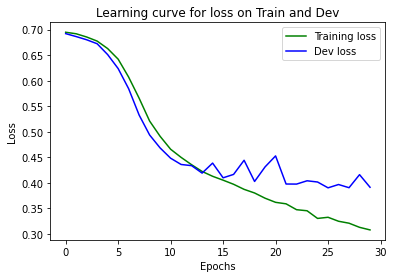

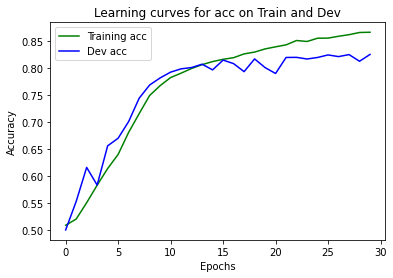

In [ ]:

 # Adding more code to print out logging 
 # Using visualization library like matplotlib to visualize training/evaluation process
 #    such as training loss, training accuracy, development loss, development accuracy

import matplotlib.pyplot as plt

# learning curve for loss function on training and development data

plt.plot(range(0,args.epoch), train_loss_list, 'g', label='Training loss')
plt.plot(range(0,args.epoch), dev_loss_list, 'b', label='Dev loss')
plt.title('Learning curve for loss on Train and Dev')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Learning curves for accuracy on training and development data


plt.plot(range(0,args.epoch), train_acc_list, 'g', label='Training acc')
plt.plot(range(0,args.epoch), dev_acc_list, 'b', label='Dev acc')
plt.title('Learning curves for acc on Train and Dev')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


